In [9]:
%pylab qt
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/jericho/anaconda3/envs/tigre_fastcat/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['det']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Load the ggems files

In [2]:
# Loop through the ggems mhd files and save them to an array
import glob
import fastcat as fc
import numpy as np
import matplotlib.pyplot as plt
import mpl_interactions as pli
from mpl_interactions import ipyplot as iplt
# Zoom the ggems projections

ggems_scatter_files = glob.glob(
    '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_dir/fastmc_*scatter.mhd'
)
ggems_primary_files = glob.glob(
    '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_dir/fastmc_*[!scatter].mhd'
)

ggems_scatter_files = [x for x in ggems_scatter_files if 'flood' not in x and '0_2' not in x]
ggems_primary_files = [x for x in ggems_primary_files if 'flood' not in x and '0_2' not in x]

ggems_scatter_files.sort()
ggems_primary_files.sort()

# Load the pickled phantom
pkl_file = '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/test/fastmc_1e10_10angles.pkl'
phantom = np.load(pkl_file, allow_pickle=True)

# I flip the phantom because fastmc has a bit of a different coordinate system
phantom.phantom = np.flipud(phantom.phantom)

# phantom.simulation_parameters['angles'] = phantom.sim_angles

# Convert the phantom angles to degrees
phantom_angles = phantom.sim_angles * 180 / np.pi

# Get the simulation parameters
# simulation_parameters = phantom.simulation_parameters
detector_material = phantom.detector_material

# spectrum_file = '/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/data/spectrum_120kVp_2mmAl.dat'
flood_file = '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_dir/fastmc_00.0_flood.mhd'

# mhd_file = '/home/jericho/1-Workspace/fastcat_gate/Catphan604.mhd'
# material_file = '/home/jericho/1-Workspace/fastcat_gate/Materials.txt'
# spectrum_file = '/home/jericho/1-Workspace/opengate_ggems_comparison/water_cylinder/data/spectrum_120kVp_2mmAl.dat'
# spectrum_file = '/home/jericho/Downloads/FastMC_Jan_05/FastMC_install/bin/data/120kV_2.5mmAl.dat'
# spectrum_file = '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/spectrum_120kVp_2.75mmAl_0.89mmTi.dat'
spectrum_file = phantom.spectrum_file
# Load the spectrum as a fastcat spectrum object
s = fc.Spectrum()
s.load(spectrum_file=spectrum_file)
s.attenuate(0.4,fc.spectrum.get_mu('13'))

det = fc.Detector(s,'CsI-784-micrometer')
# angles = np.deg2rad([0,144,216,288,72])
angles = np.linspace(0, np.pi *2, 2, endpoint=False)
phantom.angles = angles
phantom.bowtie_file = '/home/jericho/Software/Catphan604_HeadSized/full_fan_1_deg.dat'
phantom.bowtie_interp = 'cubic'

Fastcat simulation

In [3]:
# return the projections
# phantom.phantom = np.flipud(phantom.phantom)
phantom.return_projs(det,s,angles,mgy=0,
                    ASG=False, scat_on=False,
                    det_on=False,
                    bowtie=True,
                    return_intensity=True)# Get primary fastcat projections

[2024-02-15 16:59:29,846] {ggems_simulate.py:227} INFO - Initializing filter /home/jericho/Software/Catphan604_HeadSized/full_fan_1_deg.dat
[2024-02-15 16:59:30,768] {ggems_simulate.py:626} INFO - Running Simulations
[2024-02-15 16:59:30,768] {ggems_simulate.py:654} INFO -     Simulating 20 keV
[2024-02-15 16:59:31,229] {ggems_simulate.py:654} INFO -     Simulating 30 keV
[2024-02-15 16:59:31,622] {ggems_simulate.py:654} INFO -     Simulating 40 keV
[2024-02-15 16:59:32,012] {ggems_simulate.py:654} INFO -     Simulating 50 keV
[2024-02-15 16:59:32,394] {ggems_simulate.py:654} INFO -     Simulating 60 keV
[2024-02-15 16:59:32,778] {ggems_simulate.py:654} INFO -     Simulating 70 keV
[2024-02-15 16:59:33,157] {ggems_simulate.py:654} INFO -     Simulating 80 keV
[2024-02-15 16:59:33,538] {ggems_simulate.py:654} INFO -     Simulating 90 keV
[2024-02-15 16:59:33,914] {ggems_simulate.py:654} INFO -     Simulating 100 keV
[2024-02-15 16:59:34,306] {ggems_simulate.py:884} INFO - Weighting simu

In [4]:
phantom.load_ggems_files(ggems_scatter_files, ggems_primary_files, flood_file,
                         average_scatter=True)
phantom.correct_intensity(ml=False)
# len(phantom.ggems_primary_projections)

In [10]:
plt.figure()
plt.subplot(131)

from scipy.ndimage import gaussian_filter
filt_sigma = 8
int1 = gaussian_filter(phantom.ggems_primary_projections[0],filt_sigma)
int2 = gaussian_filter(phantom.intensity[0],filt_sigma)

proj1 = -np.log(int1/np.rot90(phantom.ggems_flood))
proj2 = -np.log(int2/phantom.flood_field)
# gaussian blur the projections using scipy ndimage 

crop = 20

plt.imshow(proj1[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'GGEMS $\sigma$={filt_sigma}')
plt.subplot(132)
plt.imshow(proj2[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'Fastcat $\sigma$={filt_sigma}')
# Plot the difference 
plt.subplot(133)
diff_1 = 100*(proj1[crop:-crop,crop:-crop]-proj2[crop:-crop,crop:-crop])/4
plt.axis('off')
plt.title('Difference')
plt.imshow(diff_1,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(orientation='horizontal')

# plot the mean of the difference image along both axes
plt.figure()
plt.plot(np.mean(diff_1,axis=0))
plt.plot(np.mean(diff_1,axis=1))

libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open radeonsi: /usr/lib/dri/radeonsi_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: radeonsi
libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast
/tmp/ipykernel_12617/1736637096.py:9: RuntimeWarning: divide by zero encountered in divide
  proj1 = -np.log(int1/np.rot90(phantom.ggems_flood))


In [5]:
# phantom.simulation_parameters['angles'] = np.linspace(0, np.pi *2, 2, endpoint=False)
phantom.interpolate_ggems_scatter()
phantom.add_poisson_noise()

[2024-02-15 16:59:56,723] {legend.py:1363} WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


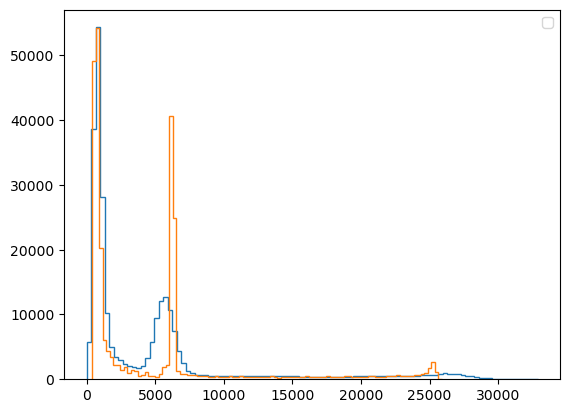

In [6]:
plt.figure()
plt.hist(phantom.ggems_primary_projections[1].flatten(), bins=100,histtype='step')
plt.hist(phantom.intensity[0].flatten(), bins=100,histtype='step')
plt.legend()

In [7]:
det = fc.Detector(s,'CsI-784-micrometer')
det.add_focal_spot(1.0)

phantom.detector_mtf_convolution(det)

In [8]:
phantom.calc_ggems_projections(scat_on=True)
phantom.reconstruct_ggems(algo='FDK')

In [144]:
fig = plt.figure(figsize=(10,5))
hi_res_bowtie_HU = phantom.img/np.mean(phantom.img[20:-20,200:-200, 200:-200])
hi_res_bowtie_HU = (hi_res_bowtie_HU-1)*1000
cont = pli.hyperslicer(hi_res_bowtie_HU, autoscale_cmap=False,cmap='bone', vmin=-400, vmax=400)#,controls=cc)
plt.colorbar()
plt.title('High res bowtie [HU]')
plt.axis('off')

(-0.5, 525.5, 525.5, -0.5)

In [145]:
phantom.save_pickle('first_layer_360.pkl')

## Now the second layer

In [146]:
spectrum_file = phantom.spectrum_file

s.load(spectrum_file=spectrum_file)
plt.figure()
plt.plot(s.x, s.y)
# s.attenuate(0.08,fc.spectrum.get_mu('CsI'))
s.attenuate(0.08,fc.spectrum.get_mu('CsI'))
s.attenuate(0.1,fc.spectrum.get_mu('14'))
plt.plot(s.x, s.y)

In [147]:
ggems_scatter_files = glob.glob(
    '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_dir/fastmc_*scatter.mhd'
)
ggems_primary_files = glob.glob(
    '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_dir/fastmc_*[!scatter].mhd'
)

ggems_scatter_files2 = [x for x in ggems_scatter_files if 'flood' not in x and '0_2' in x]
ggems_primary_files2 = [x for x in ggems_primary_files if 'flood' not in x and '0_2' in x]

ggems_scatter_files2.sort()
ggems_primary_files2.sort()

In [150]:
phantom2 = np.load(pkl_file, allow_pickle=True)
phantom2.DSD = 1515

# I flip the phantom because fastmc has a bit of a different coordinate system
phantom2.phantom = np.flipud(phantom2.phantom)

# phantom2.simulation_parameters['angles'] = phantom2.simangles

# Convert the phantom angles to degrees
phantom_angles = phantom2.sim_angles * 180 / np.pi

angles = np.linspace(0, np.pi *2, 360, endpoint=False)
phantom2.angles = angles
phantom2.bowtie_file = '/home/jericho/Software/Catphan604_HeadSized/full_fan_1_deg.dat'
phantom2.bowtie_interp = 'cubic'

In [151]:
# return the projections
# phantom.phantom = np.flipud(phantom.phantom)
phantom2.return_projs(det,s,angles,mgy=0,
                    ASG=False, scat_on=False,
                    det_on=False,
                    bowtie=True,
                    return_intensity=True)# Get primary fastcat projections

[2024-02-08 09:52:39,228] {ggems_simulate.py:227} INFO - Initializing filter /home/jericho/Software/Catphan604_HeadSized/full_fan_1_deg.dat


[2024-02-08 09:52:40,122] {ggems_simulate.py:618} INFO - Running Simulations
[2024-02-08 09:52:40,122] {ggems_simulate.py:621} INFO -     1.0 mm focal spot added
[2024-02-08 09:52:40,123] {ggems_simulate.py:646} INFO -     Simulating 20 keV
[2024-02-08 09:52:52,132] {ggems_simulate.py:646} INFO -     Simulating 30 keV
[2024-02-08 09:53:03,800] {ggems_simulate.py:646} INFO -     Simulating 40 keV
[2024-02-08 09:53:15,325] {ggems_simulate.py:646} INFO -     Simulating 50 keV
[2024-02-08 09:53:26,728] {ggems_simulate.py:646} INFO -     Simulating 60 keV
[2024-02-08 09:53:38,153] {ggems_simulate.py:646} INFO -     Simulating 70 keV
[2024-02-08 09:53:49,633] {ggems_simulate.py:646} INFO -     Simulating 80 keV
[2024-02-08 09:54:01,264] {ggems_simulate.py:646} INFO -     Simulating 90 keV
[2024-02-08 09:54:12,958] {ggems_simulate.py:646} INFO -     Simulating 100 keV
[2024-02-08 09:54:24,454] {ggems_simulate.py:876} INFO - Weighting simulations
[2024-02-08 09:54:24,457] {ggems_simulate.py:96

In [152]:
flood_file2 = '/home/jericho/1-Workspace/1-jupyter_notebooks/4-preliminary_fastmc_projections/out_dir/fastmc_00.0_flood_2.mhd'

phantom2.load_ggems_files(ggems_scatter_files2, ggems_primary_files2, flood_file2,
                         average_scatter=True)
phantom2.correct_intensity(ml=False)

In [155]:
plt.figure()
plt.subplot(131)

from scipy.ndimage import gaussian_filter
filt_sigma = 1
int1 = gaussian_filter(phantom.ggems_primary_projections[0],filt_sigma)
int2 = gaussian_filter(phantom2.ggems_primary_projections[0],filt_sigma)

proj1 = -np.log(int1/np.rot90(phantom.ggems_flood))
proj2 = -np.log(int2/np.rot90(phantom2.ggems_flood))
# gaussian blur the projections using scipy ndimage 

crop = 20

plt.imshow(proj1[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'GGEMS $\sigma$={filt_sigma}')
plt.subplot(132)
plt.imshow(proj2[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'Fastcat $\sigma$={filt_sigma}')
# Plot the difference 
plt.subplot(133)
diff_1 = 100*(proj1[crop:-crop,crop:-crop]-proj2[crop:-crop,crop:-crop])/4
plt.axis('off')
plt.title('Difference')
plt.imshow(diff_1,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(orientation='horizontal')

# plot the mean of the difference along the x and y axes
plt.figure()
plt.plot(np.mean(diff_1,axis=0))
plt.plot(np.mean(diff_1,axis=1))

/tmp/ipykernel_6155/2390269776.py:9: RuntimeWarning: divide by zero encountered in divide
  proj1 = -np.log(int1/np.rot90(phantom.ggems_flood))
/tmp/ipykernel_6155/2390269776.py:10: RuntimeWarning: divide by zero encountered in divide
  proj2 = -np.log(int2/np.rot90(phantom2.ggems_flood))


In [171]:
plt.figure()
plt.subplot(131)

from scipy.ndimage import gaussian_filter
filt_sigma = 1
int1 = gaussian_filter(phantom.intensity[0],filt_sigma)
int2 = gaussian_filter(phantom2.intensity[0],filt_sigma)

proj1 = -np.log(int1/phantom.flood_field)
proj2 = -np.log(int2/phantom2.flood_field)
# gaussian blur the projections using scipy ndimage 

crop = 20

plt.imshow(proj1[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'Layer 1 norm. filt. $\sigma$={filt_sigma}')
plt.subplot(132)
plt.imshow(proj2[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'Layer 2 norm. filt. $\sigma$={filt_sigma}')
# Plot the difference 
plt.subplot(133)
diff_1 = 100*(proj1[crop:-crop,crop:-crop]-proj2[crop:-crop,crop:-crop])/4
plt.axis('off')
plt.title('Difference')
plt.imshow(diff_1,cmap='bwr',vmin=-10,vmax=10)
plt.colorbar(orientation='horizontal')

# plot the mean of the difference along the x and y axes
plt.figure()
plt.plot(np.mean(diff_1,axis=0))
plt.plot(np.mean(diff_1,axis=1))

In [156]:
plt.figure()
plt.subplot(131)

from scipy.ndimage import gaussian_filter
filt_sigma = 1
int1 = gaussian_filter(phantom2.ggems_primary_projections[0],filt_sigma)
int2 = gaussian_filter(phantom2.intensity[0],filt_sigma)

proj1 = -np.log(int1/np.rot90(phantom2.ggems_flood))
proj2 = -np.log(int2/phantom2.flood_field)
# gaussian blur the projections using scipy ndimage 

crop = 20

plt.imshow(proj1[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'GGEMS $\sigma$={filt_sigma}')
plt.subplot(132)
plt.imshow(proj2[crop:-crop,crop:-crop],cmap='turbo',vmin=0,vmax=4)
plt.axis('off')
plt.title(f'Fastcat $\sigma$={filt_sigma}')
# Plot the difference 
plt.subplot(133)
diff_1 = 100*(proj1[crop:-crop,crop:-crop]-proj2[crop:-crop,crop:-crop])/4
plt.axis('off')
plt.title('Difference')
plt.imshow(diff_1,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(orientation='horizontal')

# plot the mean of the difference along the x and y axes
plt.figure()
plt.plot(np.mean(diff_1,axis=0))
plt.plot(np.mean(diff_1,axis=1))

/tmp/ipykernel_6155/1860078263.py:9: RuntimeWarning: divide by zero encountered in divide
  proj1 = -np.log(int1/np.rot90(phantom2.ggems_flood))


In [157]:
plt.figure(figsize=(10,5))
# plt.subplot(121)
plt.plot(np.mean(phantom2.ggems_primary_projections[0],axis=0))
plt.plot(np.mean(phantom2.ggems_flood,axis=1))
# plt.subplot(122)
plt.plot(np.mean(phantom2.intensity[0],axis=0))
plt.plot(np.mean(phantom2.flood_field,axis=0))

In [158]:
# phantom2.simulation_parameters['angles'] = np.linspace(0, np.pi *2, 2, endpoint=False)
phantom2.interpolate_ggems_scatter()
phantom2.add_poisson_noise()

In [159]:
plt.figure()
plt.hist(phantom2.ggems_primary_projections[1].flatten(), bins=100,histtype='step',label='ggems')
plt.hist(phantom2.intensity[0].flatten(), bins=100,histtype='step',label='fastcat')
plt.hist(phantom.ggems_primary_projections[1].flatten(), bins=100,histtype='step',label='ggems_1')
plt.hist(phantom.intensity[0].flatten(), bins=100,histtype='step',label='fastcat_1')
plt.legend()

# Plot the same thing but normalized
plt.figure()
plt.hist(phantom2.ggems_primary_projections[1].flatten()/phantom2.ggems_primary_projections[1].max(), bins=100,histtype='step',label='ggems')
plt.hist(phantom2.intensity[0].flatten()/phantom2.intensity[0].max(), bins=100,histtype='step',label='fastcat')
plt.hist(phantom.ggems_primary_projections[1].flatten()/phantom.ggems_primary_projections[1].max(), bins=100,histtype='step',label='ggems_1')
plt.hist(phantom.intensity[0].flatten()/phantom.intensity[0].max(), bins=100,histtype='step',label='fastcat_1')
plt.legend()


In [365]:
plt.figure()
plt.hist(phantom.proj[0].flatten(), bins=100,histtype='step',label='fastcat')
plt.hist(phantom2.proj[0].flatten(), bins=100,histtype='step',label='fastcat_2')

(array([93135.,  2662.,  2453.,   407.,  1183.,   336.,   343.,   373.,
          823.,   673.,  2308.,   407.,   325.,  1160.,   282.,   403.,
         1047.,   370.,   308.,  1115.,   343.,  1076.,   349.,   921.,
          489.,   999.,   389.,  1029.,   618.,   769.,   933.,   794.,
          653.,  1105.,   990.,   463.,   904.,   993.,  1103.,   962.,
         1054.,   959.,   862.,  1070.,  1034.,  1159.,  1000.,  1067.,
         1204.,  1147.,  1197.,  1097.,  1131.,  1361.,  1161.,  1315.,
         1190.,  1362.,  1461.,  1532.,  1470.,  1347.,  1510.,  1586.,
         1570.,  1452.,  1680.,  1357.,  1500.,  1680.,  1551.,  1842.,
         1980.,  1804.,  1941.,  1965.,  1869.,  1868.,  1811.,  2157.,
         2258.,  2070.,  1750.,  1851.,  3150.,  4800.,  3324.,  3911.,
         4416.,  5734.,  4236.,  5188.,  3527.,  3567.,  4934., 11401.,
         8570.,  1264.,  1195.,  1700.]),
 array([ 0.16441574,  0.51807065,  0.87172556,  1.22538047,  1.57903538,
         1.93269029, 

In [160]:
det = fc.Detector(s,'CsI-784-micrometer')
det.add_focal_spot(1.0)

phantom2.detector_mtf_convolution(det)

In [161]:
phantom2.calc_ggems_projections(scat_on=True)
phantom2.reconstruct_ggems(algo='FDK')

In [162]:
fig = plt.figure(figsize=(10,5))
hi_res_bowtie_HU = phantom2.img/np.mean(phantom2.img[20:-20,200:-200, 200:-200])
hi_res_bowtie_HU = (hi_res_bowtie_HU-1)*1000
cont = pli.hyperslicer(hi_res_bowtie_HU, autoscale_cmap=False,cmap='bone', vmin=-400, vmax=400)#,controls=cc)
plt.colorbar()
plt.title('High res bowtie [HU]')
plt.axis('off')

(-0.5, 525.5, 525.5, -0.5)

In [166]:
fig = plt.figure(figsize=(10,5))
plt.subplot(132)

hi_res_bowtie_HU = phantom2.img/np.mean(phantom.img[20:-20,200:-200, 200:-200])
hi_res_bowtie_HU = (hi_res_bowtie_HU-1)*1000
cont = pli.hyperslicer(hi_res_bowtie_HU, autoscale_cmap=False,cmap='bone', vmin=-400, vmax=400,play_buttons=True)#,controls=cc)
# plt.colorbar()
plt.title('Second Layer')
plt.axis('off')
plt.subplot(131)
first_layer_HU = phantom.img/np.mean(phantom.img[20:-20,200:-200, 200:-200])
first_layer_HU = (first_layer_HU-1)*1000
cc = pli.hyperslicer(first_layer_HU, autoscale_cmap=False,cmap='bone', vmin=-400, vmax=400,controls=cont)
# plt.colorbar()
plt.title('First Layer')
plt.axis('off')
plt.subplot(133)
# Plot the difference
diff = hi_res_bowtie_HU - first_layer_HU
cc = pli.hyperslicer(diff, autoscale_cmap=False,cmap='bwr', vmin=-400, vmax=400,controls=cont)
plt.colorbar()
plt.title('Difference')
plt.tight_layout()
plt.axis('off')


(-0.5, 525.5, 525.5, -0.5)

In [170]:
cont.save_animation('catphan_correct_spectrum.gif',fig = fig,param='axis0')

[2024-02-08 10:03:16,313] {animation.py:1060} INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
[2024-02-08 10:03:16,314] {animation.py:338} INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1000x500 -pix_fmt rgba -framerate 50.0 -loglevel error -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y catphan_correct_spectrum.gif


In [163]:
plt.figure()
plt.plot(phantom.weights_fluence)
plt.plot(phantom2.weights_fluence)

In [164]:
# Save the flood fields, the raw projections, and the scatter all to matlab files 

# Save the flood fields
import scipy.io as sio

sio.savemat('flood_field_first_layer.mat', {'flood_fields': phantom.flood_field})
sio.savemat('flood_field_second_layer.mat', {'flood_fields': phantom2.flood_field})

# Save the intensity
sio.savemat('detector_intensity_first_layer.mat', {'intensity': phantom.intensity})
sio.savemat('detector_intensity_second_layer.mat', {'intensity': phantom2.intensity})

# Save the scatter
sio.savemat('detector_scatter_intensity_first_layer.mat', {'scatter': phantom.interpolated_ggems_scatter})
sio.savemat('detector_scatter_intensity_second_layer.mat', {'scatter': phantom2.interpolated_ggems_scatter})


In [165]:
phantom2.save_pickle('second_layer_360.pkl')
phantom.save_pickle('first_layer_360.pkl')